# Predicting The Re-Sale Value of Used Cars

## Problem Statement

In the United States used cars represent almost half of the U.S. auto retail market and is the largest retail segment of the economy. There has been a shift by consumers to purchase more affordable previously owned vechinces as automobile debt has surpassed 1 trillion dollars and now makes up 9.5% of American consumer debt. The market for used vehicles is challenging to navigate for many consumers as prices can vary widely as many formulas fail to take into the many nuances of a car.

Consumers can use online valuation calculators to get an estimate on a car but these sites tend to only factor in a few features like make, model and miles driven. They also value the car on a straight line depreciation formula which can be overly simplistic, especially for cars that were well maintained by the previous owner. Buyers may look to third party appraisals to price a second hand car, but often these appraisals are costly and time consuming. 

In the current used car market landscape there is a need by both buyers and sellers for a price prediciton method to better determine the fair market value of a car. Individual sellers can use this price prediciton model to better price their cars before putting them on the market. Buyers can use additional predictions to reference them against popular online valuators to get a better idea of the fair market value of a car. In the often times overwhelming used car market a price predicition model that accounts for the nuances of an automobiles many features will benefit both buyers and sellers to help determine the actual worth of a used car. 

A series of regression models that will be utilized to predict the price of the cars in our dataset. These include; Linear Regression, Ridge, Lasso, Decision Trees, Random Forest, Extra Trees and Gradient Boost. The model will be evalueted using the metric Root Mean Squared Error. This metric was chosen because it provides us with a number that is more easily interpreted for our parameter of interst price(. In this case the metric will show the difference in monetary units (Euros) the predicted price was from the actual price. A benchmark RMSE score within 10% of the mean value of the cars in our dataset is how we will determine if we have a successful model. This would mean if the cars in the data set had a mean value of 5,000 a succesful RMSE score would be <= 500. A score like this would be helpful as a secondary appraisal to help consumers confirm they are paying a fair value for a used car. 

In [532]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import numpy as np

## Executive Summary

Predicting the price of used cars is an important problem that has great value in real world applications. As more consumers shift away from leasing or financing cars, more people are looking toward the used car market. Navigating the used car market can be challenging and it is unclear to many buyers and sellers as what the fair market value of a car is.  Intuition tells us that the older the car and the more miles it has on the odometer the cheaper it will be. However, in the data that was collected for this project we observed prices varying greatly in both the age and miles driven categories. This led us to believe that there are many additional features that are affecting the price of a used car. 

Given the extreme range in our target variable price we knew we would have to remove outliers on both ends of the price range. There were cars listed at over 150,000 euros and cars listed under 500 euros. For a used car prediction model we didn’t want to have cars priced extremely high as these vehicles are likely exotics or collectors items and did not represent what we believed to be the average used car. Addtionally we wanted to remove cars below 500 euros as these could be considered “junkers” and may be bought just for parts or scrap metal. During the modelling phase we kept scaling back on the max price as the scores of the model were very poor. The high price cars were making it very difficult for the model to learn. When going back to look at the distribution of prices the majority of the cars were in the 500 – 20,000 euro range. We ended up settling on this price range for our target variable. We believed this was a true representation on what a normal person would spend on a used car. Prices above this threshold were equivalent of the price of some new cars and we wanted to focus on a realistic price range for the average consumer. 

We wanted to use a number of different models in attempt to get the best score. We started with a simplified approach dropping the null values from our data set and running a linear regression model. We then went back and imputed the mode values for our categorical variables and re-ran the linear regression model where we observed an improvement in our score. Building off of that adjustment we introduced new models, Ridge and Lasso were used to regularize the (insert regularize info). Decision Tree, Random Forests and Extra Trees were used and the scores continued to improve. Finally, Gradient Boost was used where we observed our best score. 

Overall, the scores our models produced were poor. There were only a few features that had any impactful correlation on our models. Besides age and kilometers driven there was very weak correlation among the other features included in the model. The additional features created too much noise and it made it challenging for the models to learn.  When we scaled back to just a few features the noise was reduced and the models were less overfit but they still performed poorly. Due to the wide range in price amongst every feature, especially model and brand of car it made it extremely difficult for the models to make accurate price predictions. These results reinforce the idea that setting the actual price of a used automobile is extremely challenging and is most likely why straight line depreciation is used for this problem. 


### Contents:
- [Import Data](#Import-Data)
- [Data Dictionary](#Data-Dictionary)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Convert Date Columns to Datetime](#Convert-Date-Columns-to-Datetime)
- [Identify Missing Values](#Identify-Missing-Values)
- [Address Outliers In Data Set](#Address-Outliers-In-Data-Set)
- [Price](#Price)
- [Kilometers Driven](#Kilometers-Driven)
- [Power PS](#Power-PS)
- [Vehichle Type](#Vehichle-Type)
- [Car Brands](#Car-Brands)
- [Fuel Types](#Fuel-Types)
- [Kilometers vs. Price](#Kilometers-vs.-Price)
- [Transmission Type](#Transmission-Type)
- [Damage To Vehicle](#Damage-To-Vehicle)
- [Revisting Max Price](#Revisting-Max-Price)



## Import Data

In [533]:
df = pd.read_csv('./data/autos.csv', encoding = 'latin-1')

In [534]:
df['vehicleType'].value_counts()

limousine     95894
kleinwagen    80023
kombi         67564
bus           30201
cabrio        22898
coupe         19015
suv           14707
andere         3357
Name: vehicleType, dtype: int64

In [535]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [536]:
df['abtest'].value_counts()

test       192585
control    178943
Name: abtest, dtype: int64

## Data Dictionary

The data for this project was taken from autos from Kaggle. The data was scraped from "" , which is a website similar to ebay in Germany. Translation of German words will be provided at points along this notebook. 

|Column|Type|Description|
|:---|---|:---|
|Date Crawled|string|When this ad was first scraped from the website 
|Name|string|Name of the Car (Ex. VW Golf 1.87)
|Seller|string|Seller Type, Private or Dealer 
|Offer Type|string|The average sat Math score
|Price|int|Listed price of car
|AB Test|string|Offer is a test or control 
|Vehicle Type|string|Type of vehcile (SUV, Coupe, Van, etc.)
|Year of Registration|int|When the vehicle was first registered
|Gearbox|string|Transmission type (Manual or Automatic)
|PowerPs|int|Power of the car is PS
|Model|string|Model of the vehicle (VW Golf, Audi A4, BMW M3)
|Kilometer|int|Number of ilometers driven
|Month of Registraion|string|Which month the car was first registered
|Fuel Type|string|What type of fuel the car uses (Diesel, Gasoline, Electric)
|Brand|string|The Vehicle Manufactuer (Toyota, Volkwagen, Honda)
|Not Repaired Damage|string|If the car has damage that is unrepaired
|Date Created|string|The date for which the ad at ebay was created
|Postal Code|int|Postal Code of Seller/Cars location
|Last Seen|string|When the web scraper last saw the ad online

# Exploratory Data Analysis

In [537]:
df.shape

(371528, 20)

In [538]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,371528.0,17295.141865,3.587954e+06,0.0,1150.0,2950.0,7200.0,2.147484e+09
yearOfRegistration,371528.0,2004.577997,9.286660e+01,1000.0,1999.0,2003.0,2008.0,9.999000e+03
powerPS,371528.0,115.549477,1.921396e+02,0.0,70.0,105.0,150.0,2.000000e+04
kilometer,371528.0,125618.688228,4.011234e+04,5000.0,125000.0,150000.0,150000.0,1.500000e+05
monthOfRegistration,371528.0,5.734445,3.712412e+00,0.0,3.0,6.0,9.0,1.200000e+01
nrOfPictures,371528.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00
postalCode,371528.0,50820.667640,2.579908e+04,1067.0,30459.0,49610.0,71546.0,9.999800e+04


In [539]:
df.dtypes

dateCrawled            object
name                   object
seller                 object
offerType              object
price                   int64
abtest                 object
vehicleType            object
yearOfRegistration      int64
gearbox                object
powerPS                 int64
model                  object
kilometer               int64
monthOfRegistration     int64
fuelType               object
brand                  object
notRepairedDamage      object
dateCreated            object
nrOfPictures            int64
postalCode              int64
lastSeen               object
dtype: object

### Convert date columns to datetime

In [540]:
df['dateCrawled'] = pd.to_datetime(df['dateCrawled'])

In [541]:
df['dateCreated'] = pd.to_datetime(df['dateCreated'])

In [542]:
df['lastSeen'] = pd.to_datetime(df['lastSeen'])

In [543]:
df['Ad_Duration'] = df['lastSeen'] - df['dateCreated']

In [544]:
df['Ad_Duration'].dtypes

dtype('<m8[ns]')

In [545]:
#df['Ad_Duration'] = df['Ad_Duration'].astype(int)

In [546]:
ad_test = df['Ad_Duration'][0]

In [547]:
ad_test.days

14

Create a feature "Ad Duration Days" which is the number of days the ad listing has been up on the website. The number of days a car is posted on the website could be correlated to the price. 

In [548]:
df['Ad_Duration_days'] = df['Ad_Duration'].apply(lambda x: x.days)

The fields lastSeen and dateCreated could be used to estimate how long a car will online before it has been sold.

In [549]:
df.dtypes

dateCrawled             datetime64[ns]
name                            object
seller                          object
offerType                       object
price                            int64
abtest                          object
vehicleType                     object
yearOfRegistration               int64
gearbox                         object
powerPS                          int64
model                           object
kilometer                        int64
monthOfRegistration              int64
fuelType                        object
brand                           object
notRepairedDamage               object
dateCreated             datetime64[ns]
nrOfPictures                     int64
postalCode                       int64
lastSeen                datetime64[ns]
Ad_Duration            timedelta64[ns]
Ad_Duration_days                 int64
dtype: object

### Identify Missing Values

In [550]:
df.isnull().sum()

dateCrawled                0
name                       0
seller                     0
offerType                  0
price                      0
abtest                     0
vehicleType            37869
yearOfRegistration         0
gearbox                20209
powerPS                    0
model                  20484
kilometer                  0
monthOfRegistration        0
fuelType               33386
brand                      0
notRepairedDamage      72060
dateCreated                0
nrOfPictures               0
postalCode                 0
lastSeen                   0
Ad_Duration                0
Ad_Duration_days           0
dtype: int64

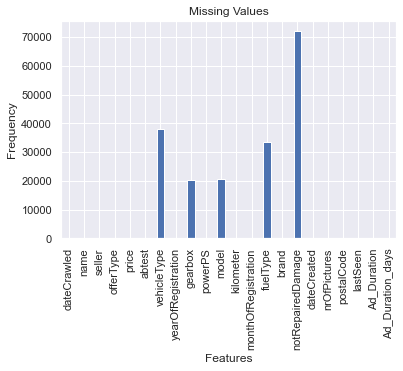

In [551]:
#visualize null values
plt.title("Missing Values")
plt.xlabel("Features")
plt.ylabel("Frequency")
df.isnull().sum().plot(kind = 'bar');

Determine if any null values are less than 5% of the dataset. If so we may just drop the null values from the dataset, if not we will have to impute the missing data or take a pattern submodel approach if possible. 

In [552]:
nulls = df.isnull().sum()
nulls = pd.DataFrame(nulls, columns = ['null'])
total = len(df)
nulls['percent']  = nulls['null']/total
nulls.sort_values('percent', ascending = False)

,null,percent
notRepairedDamage,72060,0.193956
vehicleType,37869,0.101928
fuelType,33386,0.089861
model,20484,0.055134
gearbox,20209,0.054394
dateCrawled,0,0.000000
Ad_Duration,0,0.000000
lastSeen,0,0.000000
postalCode,0,0.000000
nrOfPictures,0,0.000000


#### Missing Data

Is the missing data Missing Completely At Random (MCAR), Missing At Random (MAR) or Not Missing At Random (NMAR). Look to see if any of the columns have a higher number of shared nulls to see if a pattern submodel approach can be taken to handle the missing data. 

In [553]:
no_damage = df['notRepairedDamage'].isnull()
vtype = df["vehicleType"].isnull()
shared_null = no_damage & vtype

In [554]:
print(f"No Damage Nulls: {sum(no_damage)}")
print(f"Vehicle Type Nulls: {sum(vtype)}")
print(f"Shared Nulls: {sum(shared_null)}")

No Damage Nulls: 72060
Vehicle Type Nulls: 37869
Shared Nulls: 20756


In [555]:
vehicle_nulls = df["vehicleType"].isnull()
fuel_nulls = df["fuelType"].isnull()
shared_nulls = vehicle_nulls & fuel_nulls

In [556]:
print(f"Vehicle Type Nulls: {sum(vehicle_nulls)}")
print(f"Fuel Type Nulls: {sum(fuel_nulls)}")
print(f"Shared Nulls: {sum(shared_nulls)}")

Vehicle Type Nulls: 37869
Fuel Type Nulls: 33386
Shared Nulls: 17495


In [557]:
gearbox_nulls = df["gearbox"].isnull()
model_nulls = df["model"].isnull()
shared_nulls_1 = gearbox_nulls & model_nulls

In [558]:
print(f"Gearbox Nulls: {sum(gearbox_nulls)}")
print(f"Model Nulls: {sum(model_nulls)}")
print(f"Shared Nulls: {sum(shared_nulls_1)}")

Gearbox Nulls: 20209
Model Nulls: 20484
Shared Nulls: 4233


In [559]:
vehicle_type_nulls = df["vehicleType"].isnull()
model_nulls1 = df["model"].isnull()
shared_nulls_2 = vehicle_type_nulls & model_nulls

In [560]:
print(f"Gearbox Nulls: {sum(vehicle_type_nulls)}")
print(f"Model Nulls: {sum(model_nulls1)}")
print(f"Shared Nulls: {sum(shared_nulls_2)}")

Gearbox Nulls: 37869
Model Nulls: 20484
Shared Nulls: 6917


The missing data in this data set appears to be missing completely at random (MCAR). We anlayzed the shared null values of our features with missing values and observed a low percentage of shared nulls amongst them. Initially we wanted to use a pattern sub model approach to address the missing data but because the data is MCAR using multiple imputation or a missingness indicator can perform just as well as the pattern submodel approach

## Address Outliers In Data Set

## Price

In [561]:
print(f'Mean Price of Cars: {df.price.mean()}')
print(f'Median Price of Cars: {df.price.median()}')
print(f'Max Car Price: {df.price.max()}') 
print(f'Min Car Price: {df.price.min()}')

Mean Price of Cars: 17295.14186548524
Median Price of Cars: 2950.0
Max Car Price: 2147483647
Min Car Price: 0


In [562]:
df[df['price'] == 0].shape

(10778, 22)

In [563]:
df[df['price'] > 20_000].shape

(17144, 22)

In [564]:
df[df['price'] < 500].shape

(36062, 22)

In [565]:
#get percentage of cars above 150,000 (df[df['price'] > 150_000].value_counts(nomralize = True))
len(df[df.price > 15000]) / len(df)

0.08620346245774207

In [566]:
df = df[df['price'] >= 499]

Setting the min at 500 as outside research shows you can expect about $250-$500 for your junk car, depending on the vehicle's weight. We want to eliminate cars in the junk status range as a consumer is unlikely to purchase an car in this condition to actual use for transportation purposes.

In [567]:
df = df[df['price'] <= 150_000]

In [568]:
df.shape

(335905, 22)

In [569]:
print(f'Mean Price of Cars: {df.price.mean()}')
print(f'Median Price of Cars: {df.price.median()}')
print(f'Max Car Price: {df.price.max()}') 
print(f'Min Car Price: {df.price.min()}')

Mean Price of Cars: 6238.0633661303045
Median Price of Cars: 3500.0
Max Car Price: 150000
Min Car Price: 499


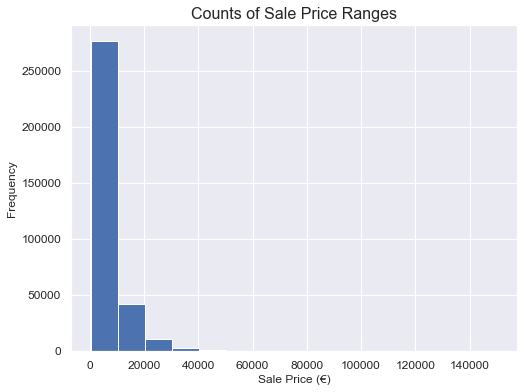

In [570]:
size = 12
plt.figure(figsize=(8,6))
plt.title("Counts of Sale Price Ranges", size = 16)
plt.xlabel("Sale Price (€)")
plt.ylabel("Frequency",)
plt.xticks(size = size)
plt.yticks(size = size)
df["price"].hist(bins = 15);

There are cars that a worth more than 150,000 euro and after further inspection they do look legitimately priced as they are exotic or luxury cars. Since most of the data is clustered toward the low end of the price range (between 5,000 - 10,000 euros) we decided to only focused on vehicles between 500 euro and 20,000 euro. We have a considerable range in the quality of automobiles in our dataset. Only the lower range we have cars that could be consdiered "junkers" all the way up to luxury automobiles. However, the collectors items are the outliers in the dataset and we felt they could be included up until a certain point, there were only 232 cars priced over 150,000 so we decided to establish our max price there. Max price may be reduced if we observe poor RMSE scores. The metric RMSE is greatly affected by outliers and this is something to be aware of once we begin modeling. 

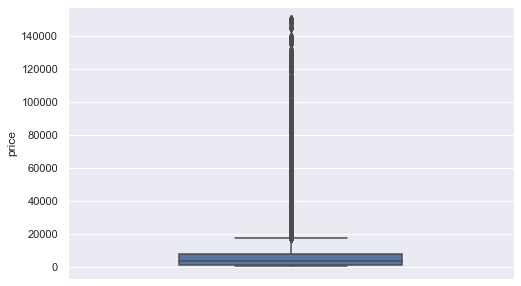

In [571]:
#need a title & reduce size to show a better box plot 
plt.figure(figsize=(8,5))
sns.boxplot(y='price', data=df, width=0.5);

The above box plot is somewhat hard to interpret because we have so many outliers. The majority of cars in our data set are less than €10,000 with a mean value just under €5,000. The upper quartile range is around €7,500. We observe litte spread between the firt quartile and third quartlie range but due to the large number of outliers it gives our box plot the squashed appearence. We have a lot of data in our data set and a large number of outliers. 

In [572]:
adjusted_price = np.log(df['price'])

In [573]:
print(f'Mean Log of Car Prices: {adjusted_price.mean()}')
print(f'Median Log of Car Prices: {adjusted_price.median()}')
print(f'Max Log of Car Prices: {adjusted_price.max()}') 
print(f'Min Log of Car Prices: {adjusted_price.min()}')

Mean Log of Car Prices: 8.171698472870407
Median Log of Car Prices: 8.160518247477505
Max Log of Car Prices: 11.918390573078392
Min Log of Car Prices: 6.212606095751519


Insert comments on adjusting prices to log values

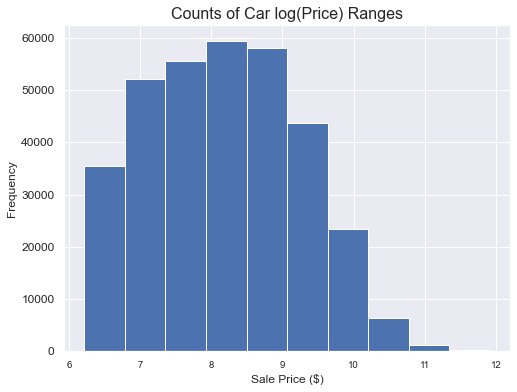

In [574]:
size = 12
plt.figure(figsize=(8,6))
plt.title("Counts of Car log(Price) Ranges", size = 16)
plt.xlabel("Sale Price ($)")
plt.ylabel("Frequency")
plt.xticks(size = size * 4/5)
plt.yticks(size = size)
adjusted_price.hist(bins = 10);

Insert write up on log price 

In [575]:
df['price_ln'] = np.log(df['price'])

### Kilometers Driven

In [576]:
df.kilometer.value_counts(normalize = True)

150000    0.636570
125000    0.106346
100000    0.044158
90000     0.035742
80000     0.031711
70000     0.028234
60000     0.025215
50000     0.022104
40000     0.018589
30000     0.017213
20000     0.015725
5000      0.013167
10000     0.005225
Name: kilometer, dtype: float64

In [577]:
print(f'Mean Kilometers Driven: {df.kilometer.mean()}')
print(f'Median Kilometers Driven: {df.kilometer.median()}')
print(f'Max Kilometers Driven: {df.kilometer.max()}') 
print(f'Min Kilometers Driven: {df.kilometer.min()}')

Mean Kilometers Driven: 125235.27485449755
Median Kilometers Driven: 150000.0
Max Kilometers Driven: 150000
Min Kilometers Driven: 5000


In [578]:
df[df['kilometer'] < 5_000].shape

(0, 23)

In [579]:
df[df['kilometer'] > 200_000].shape

(0, 23)

In [580]:
df = df[df['kilometer'] > 5000]

In [581]:
df.shape

(331482, 23)

In [582]:
pvt = df.pivot_table(index = 'kilometer',
                          values = 'price', aggfunc = np.mean)

<Figure size 1440x1296 with 0 Axes>

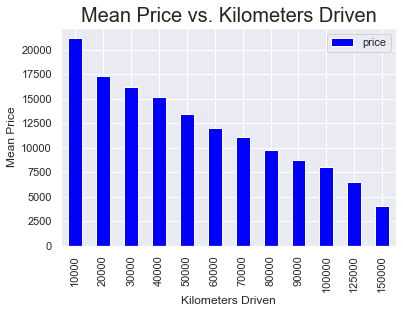

In [583]:
plt.figure(figsize =(20, 18))
pvt.plot(kind = 'bar', color = 'blue')
plt.xlabel('Kilometers Driven')
plt.ylabel('Mean Price')
plt.xticks(rotation = 90)
plt.xticks(rotation=90)
plt.title('Mean Price vs. Kilometers Driven', size = 20);

Exact number of kilometers driven is not given, instead the number of of kilometers driven is segmented into categories; from 5,000 - 10,000 and then increasing by 10,000 until 100,000 where it increases by 25,000 k per grouping. 

In [584]:
df[df['yearOfRegistration'] < 1970].shape

(1198, 23)

In [585]:
df[df['yearOfRegistration'] > 2020].shape

(38, 23)

In [586]:
df = df[(df['yearOfRegistration'] > 1970) | (df['yearOfRegistration'] < 2020)]

In [587]:
df = df[df['yearOfRegistration'] > 1970]

In [588]:
df = df[df['yearOfRegistration'] < 2020]

In [589]:
df['age'] = 2017 - df['yearOfRegistration']

In [590]:
df.drop(columns = 'yearOfRegistration', inplace = True)

In [591]:
df.age.value_counts


<bound method IndexOpsMixin.value_counts of 1          6
2         13
3         16
4          9
5         22
          ..
371523    12
371524    17
371525    21
371526    15
371527     4
Name: age, Length: 330017, dtype: int64>

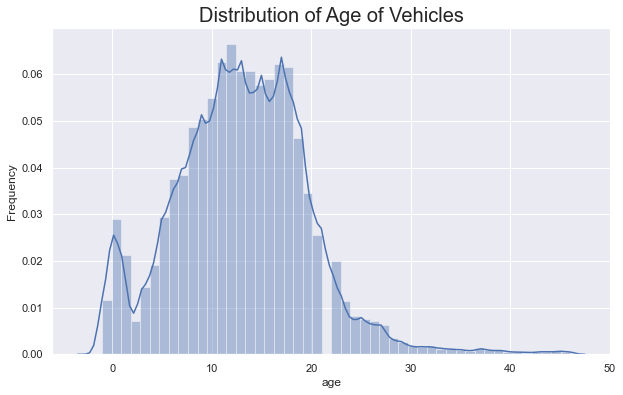

In [592]:
plt.figure(figsize=(10,6))

sns.distplot(df['age']).set_title('Distribution of Age of Vehicles', size = 20)
plt.ylabel('Frequency');

Year Of Registration is the year the car was first registered. We can infer from this information that this is the approximate age of the car. The year of registration will be subtracted from the year the data was collect (2017) to create an age feature in our dataset. The dataset included some outliers that we knew not to be true, such as cars listed from the year 1400 or 8455. These extremes could be removed because cars were not around in the 15th century and it is unlikely we would have cars from the future available on this list of pre-owned vehichles. There were cars that dated back to the early 20th century. However we will exclude cars before 1970 as it was only a small percentage of our dataset and these cars may be antiques or classics that may throw off our predicitons. This dataset is primarily focused on your typical used automobile that the average person would drive. We want to reduce the number of exotic or antique cars to get a better predicitons. 

## Power PS

Although it’s still commonly used by carmakers, PS or Pferdestärke (horse strength in German) was actually replaced by kW as the EU's ‘legal’ measurement of engine power in 1992.  One PS is about 98.6% of a brake horsepower – the two are virtually interchangeable, and PS is sometimes referred to as 'metric horsepower'.



In [593]:
#convert Power PS to kW & drop Power PS from columns when creating features(X)
#df['Power_kW'] = df['PowerPS'] * .986

In [594]:
print(f'Mean Power PS D: {df.powerPS.mean()}')
print(f'Median Power PS: {df.powerPS.median()}')
print(f'Max Power PS: {df.powerPS.max()}') 
print(f'Min Power PS: {df.powerPS.min()}')

Mean Power PS D: 120.67007154176906
Median Power PS: 110.0
Max Power PS: 20000
Min Power PS: 0


In [595]:
df.shape

(330017, 23)

In [596]:
df[df['powerPS'] == 0].shape

(27690, 23)

In [597]:
df[df['powerPS'] > 1000].shape

(236, 23)

In [598]:
df = df[(df['powerPS'] < 1000) | (df['powerPS'] > 0)]

In [599]:
# convert powerPS to Kw (insert markdwon cell on why)
df['KwPower'] = df['powerPS'] * 0.7355

In [600]:
df.drop(columns = 'powerPS', inplace = True)

## Address Null Values

All of the categories that have null values are categorical features. The first feature we wanted to address was model. We reviewed the value counts of each model for each brand and used the mode to to replace the missing data. The feature model had null values that was just over 5%. This is usually the threshold to just drop the missing data, but we wanted to replace the null values with the mode to see it's performance on the model. We will then remove these imputed values and run the model again to see which performs better. 

In [601]:
df['vehicleType'].value_counts()

limousine     88726
kleinwagen    67814
kombi         62676
bus           28927
cabrio        21706
coupe         16991
suv           14097
andere         2652
Name: vehicleType, dtype: int64

#### Model Null Values

We will impute missing model types from our dataset with the mode value of each brand. For Volkswagen missing model types will be imputed with the moddel golf. 

In [602]:
df.model.value_counts()

golf               26801
andere             22763
3er                19083
polo               10598
corsa               9807
                   ...  
samara                 5
serie_2                4
serie_3                3
serie_1                1
discovery_sport        1
Name: model, Length: 251, dtype: int64

In [603]:
vtype_mode = df.groupby('model')['vehicleType'].agg(pd.Series.mode)

In [604]:
for i,vtype in vtype_mode.iteritems():
    if len(vtype) == 2:
        print(i,vtype)
    

#vtype_mode.replace(np.array(['kleinwagen', 'limousine']), 'limousine').value_counts()

elefantino ['kleinwagen' 'limousine']
superb ['kombi' 'limousine']


In [605]:
vtype_mode['elefantino'] = 'limousine'
vtype_mode['superb'] = 'limousine'
vtype_mode['serie_2'] = 'suv'

In [606]:
df['vehicleType'].fillna(df['model'], inplace = True)

In [607]:
df['vehicleType'] = df['vehicleType'].map(vtype_mode.to_dict()).fillna(df['vehicleType'])

In [608]:
brand_mode = df.groupby('brand')['model'].agg(pd.Series.mode)

In [609]:
df['model'].fillna(df['brand'], inplace = True)

In [610]:
brand_mode.to_dict()

{'alfa_romeo': '147',
 'audi': 'a4',
 'bmw': '3er',
 'chevrolet': 'andere',
 'chrysler': 'andere',
 'citroen': 'andere',
 'dacia': 'logan',
 'daewoo': 'matiz',
 'daihatsu': 'cuore',
 'fiat': 'punto',
 'ford': 'focus',
 'honda': 'civic',
 'hyundai': 'i_reihe',
 'jaguar': 'andere',
 'jeep': 'grand',
 'kia': 'andere',
 'lada': 'niva',
 'lancia': 'ypsilon',
 'land_rover': 'freelander',
 'mazda': '6_reihe',
 'mercedes_benz': 'c_klasse',
 'mini': 'cooper',
 'mitsubishi': 'colt',
 'nissan': 'micra',
 'opel': 'corsa',
 'peugeot': '2_reihe',
 'porsche': '911',
 'renault': 'twingo',
 'rover': 'andere',
 'saab': 'andere',
 'seat': 'ibiza',
 'skoda': 'octavia',
 'smart': 'fortwo',
 'sonstige_autos': array([], dtype=object),
 'subaru': 'impreza',
 'suzuki': 'andere',
 'toyota': 'yaris',
 'trabant': '601',
 'volkswagen': 'golf',
 'volvo': 'v40'}

In [611]:
df['model'] = df['model'].map(brand_mode.to_dict()).fillna(df['model'])

In [612]:
df[df['brand'] == 'sonstige_autos']['model'] = 'andere'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [613]:
df.drop(columns = 'nrOfPictures', inplace = True)

nrofPictures column did not have any data. It appears there was an error when scraping the information from the website. This column will be dropped. 

#### Fuel Type & Gearbox

In [614]:
df.fuelType.value_counts(normalize = True)

benzin     0.641339
diesel     0.338984
lpg        0.016487
cng        0.001731
hybrid     0.000853
andere     0.000332
elektro    0.000273
Name: fuelType, dtype: float64

In [615]:
df[['gearbox', 'fuelType']].mode()

,gearbox,fuelType
0,manuell,benzin


In [616]:
df['gearbox'].fillna(df['gearbox'].mode().values[0], inplace = True)

In [617]:
df['fuelType'].fillna(df['fuelType'].mode().values[0], inplace = True)

Imputed mode values of gearbox also known as transmission types. Manual transmissions were by far the most common transmission type so this was our best method to address the null values. Also there are only two types of transmissions so imputing the wrong value is less likey. This is not ideal to address null values but we don't want to just drop data from our dataset. 

#### Unrepaired Damage

If the car has  damage which has not repaired yet been repaired. This is a feature that could greatly impact the re-sale value of a car and is something that most likely cannot be hidden from a potential buyer. To address the null values in this category we will assume a null value means there is no un-repaired damage and the value will be filled with the answer 'nein' (no). If did not have any damange and thus did not need repair it is likely a seller ommitted an answer all together from this category. 

In [618]:
df['notRepairedDamage'].unique()

array(['ja', nan, 'nein'], dtype=object)

In [619]:
df['notRepairedDamage'].fillna('nein', inplace = True)

In [620]:
#gewerblich/commercial(english) all other sellers are private 
df.groupby('seller').size()

seller
gewerblich         1
privat        330016
dtype: int64

In [621]:
df.offerType.value_counts()

Angebot    330014
Gesuch          3
Name: offerType, dtype: int64

### Vehichle Type

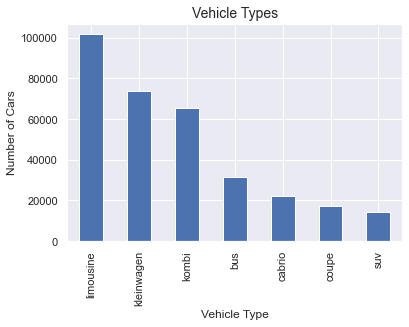

In [622]:
df['vehicleType'].value_counts().plot(kind = 'bar')
plt.title('Vehicle Types', size = 14)
plt.xlabel('Vehicle Type')
plt.ylabel('Number of Cars');

__English Translations__ 

Limousine - Sedan

Kleinwagen - Compact Car

Kombi - Minibus

Cabrio - Convertible 




The most common vehicle types in the data set are Sedans and compact cars. Europeans tend to drive smaller more fuel efficient cars because of the price of fuel in Europe is more expensive than the United States. We observe a small number of SUV's and no pickup trucks. 

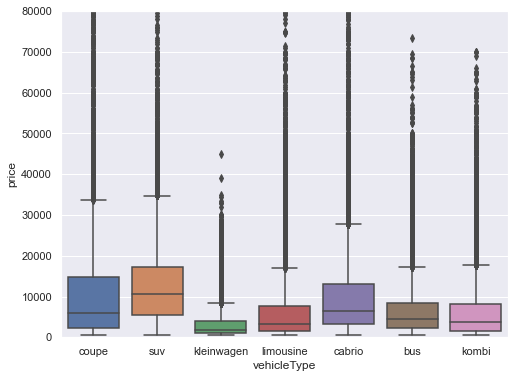

In [623]:
var = 'vehicleType'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=80000);

Again we see a vast range of prices from somewhere in the low hundreds all the way up to 100,000. The box plots help visualize that most of the vehicle types listed have prices that are clustered below the 20,000 euro ranges. We can infer from the box plot that SUV's have the highest re-sale prices while the small compact car (kleinwagen) have the lowest retail price.

## Car Brands

In [624]:
df.brand.value_counts(normalize = True)

volkswagen        0.214331
bmw               0.113937
mercedes_benz     0.101583
opel              0.100937
audi              0.093368
ford              0.063954
renault           0.045161
peugeot           0.029989
fiat              0.024114
seat              0.018823
skoda             0.016293
smart             0.015351
mazda             0.015275
citroen           0.013939
toyota            0.013672
nissan            0.013293
hyundai           0.010372
mini              0.009975
volvo             0.009000
mitsubishi        0.007797
honda             0.007687
sonstige_autos    0.007415
kia               0.007221
suzuki            0.006233
alfa_romeo        0.006175
porsche           0.006024
chevrolet         0.005051
chrysler          0.003836
dacia             0.002660
jeep              0.002264
land_rover        0.002215
subaru            0.001973
daihatsu          0.001836
jaguar            0.001703
saab              0.001479
daewoo            0.001270
lancia            0.001164
r

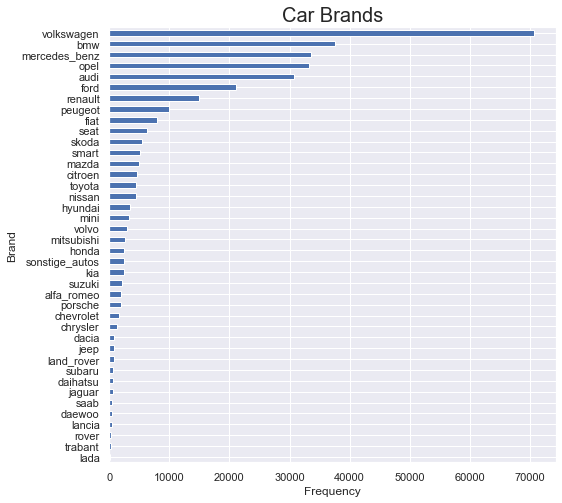

In [625]:
#Visualize the frequency of brands in the dataset (add labels)
plt.figure(figsize = (8,8))
df.brand.value_counts(ascending = True).plot(kind = 'barh')
plt.title('Car Brands', size = 20)
plt.xlabel('Frequency')
plt.ylabel('Brand');

It comes as no surprise that four of the five most common brands are German manufacturers as this data was scraped from a German website. Volkswagen is the most common car making up approximately 20% of our dataset. Volkswagen roughy translages to the peoples car and this makes sense now as we see how popular of a car it is with German consumers. Volkswagens are affordable and reliable cars that have good fuel economy, which is very important to European consumers because of the price of gas in Europe. We only observe one car brand that comes from outside of Europe in the top 10. Ford ranks sixth on this list and outside research shows Ford has a large presence in Germany with a factory in Cologne. Fords are one of the most popular foregin (outside of Europe) car makers in Germany. 

In [626]:
mean_price_brand = df.pivot_table(index = 'brand',
                          values = 'price', aggfunc = np.mean)

<Figure size 1440x1440 with 0 Axes>

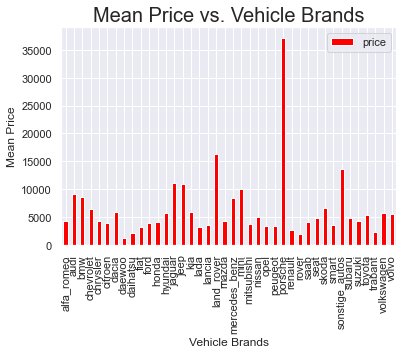

In [627]:
plt.figure(figsize =(20, 20))
mean_price_brand.plot(kind = 'bar', color = 'red')
plt.xlabel('Vehicle Brands')
plt.ylabel('Mean Price')
plt.xticks(rotation = 90)

plt.title('Mean Price vs. Vehicle Brands', size = 20);

Above we obeserve the mean prices of the brands of vehicles in our data set. Most of the brands mean prices are below €10,000. Only two brand Land Rover and Porsche have mean values of over €15,000. Even other luxury brands like BMW and Audi have low mean prices. This is not surprising as consumers of used cars are probably not interested in spending more than €10,000. At that point you start to enter the new car price range. 

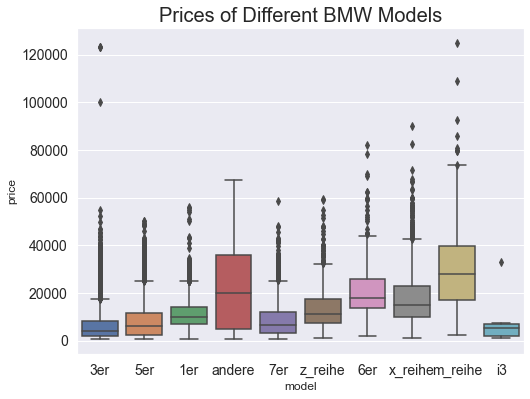

In [628]:
size= 14
plt.figure(figsize=(8,6))
sns.set(style='darkgrid')
sns.boxplot(x='model', y='price', data=df[df.brand == 'bmw']).\
set_title('Prices of Different BMW Models', size = 20)
fig.axis(ymin=0, ymax=80000);
plt.xticks(rotation=0, size = size)
plt.yticks(size = size);

When comparing the vehicle brands to price we observe prices for some brands range from close to 0 up to 100,000  BMWs have a great range in price. This is most likely due to the age, number or kilometers and condition of the cars. This brand is considered luxury and some models can retail for over €60,000. However, most of the cars are below €20,000. This is what makes the resale value of cars interesting as they are a depreciating asset and it is difficult to maintain their value. We observe in the above visualization that even luxury automobiles can become "clunkers" after enough time on the road and wear and tear. 

Automobiles are depreciating assets so as soon as they are purchased and driven off the lot their price begins to drop. Increasing the mileage as well as addtional wear and tear to a vehicle are contributing factors to price depreciation. This is why we observe this range of prices

### Fuel Types

In [629]:
df.fuelType.value_counts(normalize = True)

benzin     0.666002
diesel     0.315675
lpg        0.015354
cng        0.001612
hybrid     0.000794
andere     0.000309
elektro    0.000255
Name: fuelType, dtype: float64

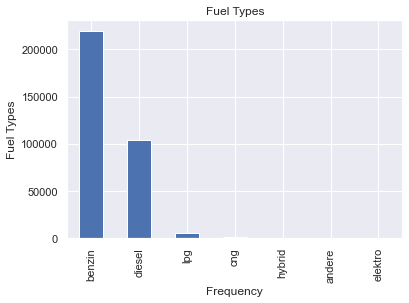

In [630]:
#klienwagen is a compact car, kombi is a minibus, andere is other, limousine is a sedan, change names to english words!

df['fuelType'].value_counts().plot(kind = 'bar')
plt.title('Fuel Types')
plt.xlabel('Frequency')
plt.ylabel('Fuel Types');

Insert write up on Fuel Types 

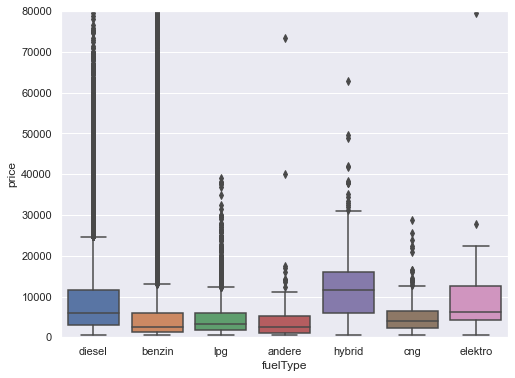

In [631]:
#Title!!!
var = 'fuelType'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=80000);

Again we see a vast range of prices from somewhere in the low hundreds all the way up to 100,000. The box plots help visualize that most of the vehicle types listed have prices that are clustered below the 20,000 euro ranges. We can infer from the box plot that vehicles with hybrid fuel types have the highest re-sale prices. For gasoline (benzin) which is the most common fuel type in our data set we observe a mean value in the low thousands and the third quartile range in the mid thousands and a maximu of approximatley 14,000 euros. Outliers continue all the way up to the ymax setting of the box plot. The graph shows us again the large number of outliers in the dataset. The same observation for gasoline engines is observed for diesel, the second most common fuel type. The other fuel types make up only a small percentage of total fuel types but they follow similar patterns as gasoline and diesel engines.  

In [632]:
#vehichle Type vs. Price (insert visual)

#plt.figure(figsize=(10,6))
#sns.regplot(x='vehicleType', y='price', data=df).set_title('Age vs Price')

### Kilometers vs. Price

Text(0.5, 1.0, 'Km vs Price')

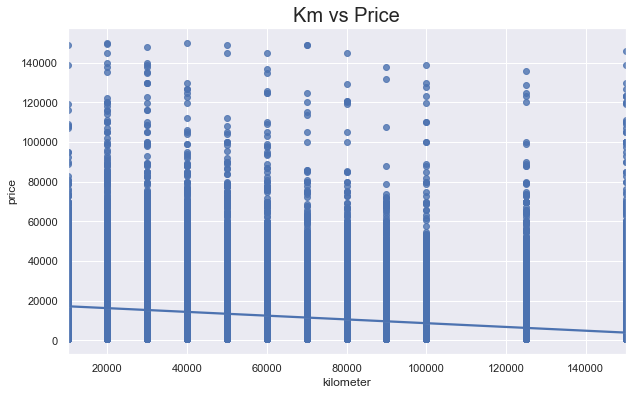

In [633]:
plt.figure(figsize=(10,6))
sns.regplot(x='kilometer', y='price', data=df).set_title('Km vs Price', size = 20)

The above scatterplot shows that an increase in kilometers driven reduces the sale price of the car. This is no surprise as usually the first question a buyer has about a pre-owned vehicle is how many miles/kilometers it has been driven. This represents the wear on the automobile and usually a buyer can deduce how much more time on the road the car can be driven. 

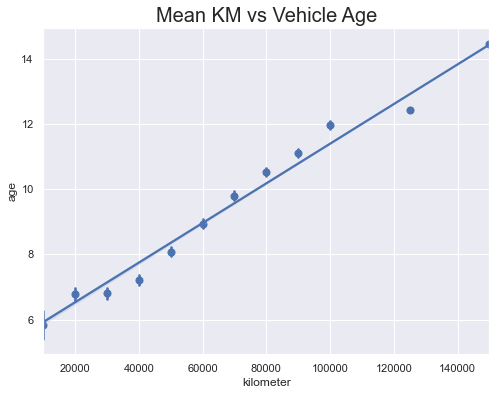

In [634]:
# cars with less than 400,000 kms
plt.figure(figsize=(8,6))
sns.regplot(x='kilometer', y='age', data=df, x_estimator = np.mean).set_title('Mean KM vs Vehicle Age', size = 20);

We observe a trend between age and kilometers. This is to be expected as the majority of the cars for sale are old cars that most likely have been driven a considerable amount. Initially we believed there would be a correlation between older cars and kilometers driven which the above graph shows.

### Transmission Type

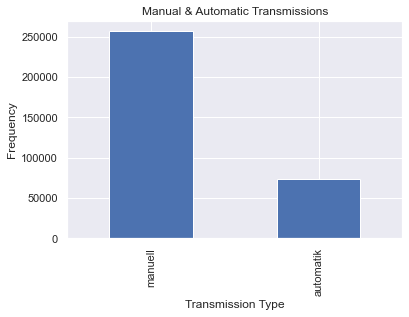

In [635]:
df['gearbox'].value_counts().plot(kind = 'bar')
plt.title('Manual & Automatic Transmissions')
plt.xlabel('Transmission Type')
plt.ylabel('Frequency');

Manual cars are about $1,000 cheaper than automatics on average, as of 2019. In addition, older manuals have a greater fuel economy than automatics of a similar age. That's not just because manual cars lack fuel-draining torque converters. It's also because manual cars have lighter transmissions. Manual transmissions are much popular in Europe which is were this data is derived from. 

In [636]:
gb_pvt = df.pivot_table(index = 'gearbox',
                          values = 'price', aggfunc = np.mean)

<Figure size 1152x648 with 0 Axes>

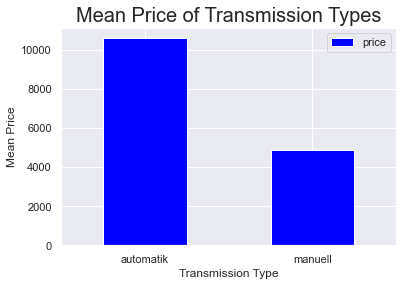

In [637]:
plt.figure(figsize =(16, 9))
gb_pvt.plot(kind = 'bar', color = 'blue')
plt.xlabel('Transmission Type')
plt.ylabel('Mean Price')
plt.xticks(rotation = 0)
plt.title('Mean Price of Transmission Types', size = 20);

Mean prices of automitic cars is about 5,000 euro more than manual cars. However, automatic cars are much rarer in our dataset. Outside research shows on average manual cars are approximately 1,000 euro less than manual cars. This does not apply in our data as there is a considerable difference in price for this feature. The automatic transmissions are much less common and more expensive in our data. This may be due to buyers who have more money to spend on a car and want certain specifications like an automatic transmission. 

### Damage To Vehicle

In [638]:
df.notRepairedDamage.value_counts()

nein    303756
ja       26261
Name: notRepairedDamage, dtype: int64

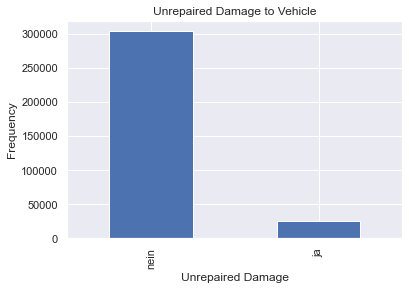

In [639]:
df['notRepairedDamage'].value_counts().plot(kind = 'bar')
plt.title('Unrepaired Damage to Vehicle')
plt.xlabel('Unrepaired Damage')
plt.ylabel('Frequency');

notRepairedDamage means there is unrepaired damage to the vehicle. this feature will negatively affect
the price of a car. A small number of vehicles in our data set have unrepaired damange, which will likely have a negative impact on the price of a car. Damage could range from a minor dent to severe damage to the body of a car. Without having specifics it will be difficult to understand the true impact this feature will have on price.  

After analyzing the features we believe will have the greatest correlation to price we can say with some confidence that we will be able to answer the problem in question, which is to accurately predict the resale prices of used cars. There is some concern about the number of outliers in our dataset but because so much of the data is clustered on the lower end of the price range we may be able to avoid any issues with outliers. Scaling back on max price may be done to eliminate outliers so we can focus on a smaller range in price. Outside research shows that the average consumer would not be looking for a used car priced above €20,000 because at this threshold most people would look toward a new car. 

In [640]:
df.describe()

,price,kilometer,monthOfRegistration,postalCode,Ad_Duration,Ad_Duration_days,price_ln,age,KwPower
count,330017.000000,330017.000000,330017.000000,330017.000000,330017,330017.000000,330017.000000,330017.000000,330017.000000
mean,6148.184472,127012.184221,5.943730,51294.802437,9 days 11:35:09.990964,8.968014,8.166785,13.032135,88.752838
std,7806.310155,37244.929655,3.624079,25715.029588,8 days 17:15:14.778607,8.753292,1.060763,6.785051,131.768928
min,499.000000,10000.000000,0.000000,1067.000000,0 days 00:25:36,0.000000,6.212606,-2.000000,0.000000
25%,1500.000000,125000.000000,3.000000,30982.000000,2 days 14:56:44,2.000000,7.313220,9.000000,55.162500
50%,3500.000000,150000.000000,6.000000,50226.000000,6 days 15:16:44,6.000000,8.160518,13.000000,80.905000
75%,7899.000000,150000.000000,9.000000,72141.000000,14 days 06:16:09,14.000000,8.974491,17.000000,110.325000
max,150000.000000,150000.000000,12.000000,99998.000000,759 days 04:46:24,759.000000,11.918391,46.000000,14710.000000


In [641]:
df.corr()

,price,kilometer,monthOfRegistration,postalCode,Ad_Duration_days,price_ln,age,KwPower
price,1.000000,-0.452643,0.047606,0.074535,0.128511,0.803819,-0.361881,0.208756
kilometer,-0.452643,1.000000,-0.025882,-0.037263,-0.092032,-0.452231,0.333498,-0.016111
monthOfRegistration,0.047606,-0.025882,1.000000,0.006509,-0.000299,0.085209,-0.018317,0.028711
postalCode,0.074535,-0.037263,0.006509,1.000000,0.030905,0.079190,-0.025752,0.025925
Ad_Duration_days,0.128511,-0.092032,-0.000299,0.030905,1.000000,0.158459,-0.028929,0.029268
price_ln,0.803819,-0.452231,0.085209,0.079190,0.158459,1.000000,-0.470073,0.205093
age,-0.361881,0.333498,-0.018317,-0.025752,-0.028929,-0.470073,1.000000,-0.048122
KwPower,0.208756,-0.016111,0.028711,0.025925,0.029268,0.205093,-0.048122,1.000000


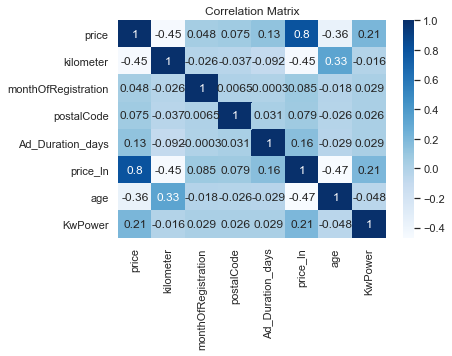

In [642]:
sns.heatmap(df.corr(), cmap = 'Blues', annot = True).set_title('Correlation Matrix');

The heatmap above gives us an idea heading into the modeling phase of our project of what features have the strongest linear relationship with price as well as with other features. We don't observe many strong correlations above besides kilometer and price. This is a cause for concern because without strong correlated features the models may have a difficult time making accurate predictions. 

### Revisting Max Price

After running models with a max price of 150,000 we observed RMSE scores above our baseline score. We believed the outliers in the data were having a sizeable affect on our models performance. We keep reducing the price until we were able to see RMSE scores drop below the baseline score.Price max reduced to 20,000 euro as model scores were performing poorly, returning results worse than our baseline model. 70%+ of our data was within this range so there is still a sufficient amount of data for prediction. 

In [643]:
df = df[df['price'] <= 20_000]

In [644]:
print(f'Mean Price of Cars: {df.price.mean()}')
print(f'Median Price of Cars: {df.price.median()}')
print(f'Max Car Price: {df.price.max()}') 
print(f'Min Car Price: {df.price.min()}')

Mean Price of Cars: 4878.129327665536
Median Price of Cars: 3200.0
Max Car Price: 20000
Min Car Price: 499


In [645]:
df.shape

(314055, 22)

In [646]:
df.to_csv('./data/car_data.csv', index = False)